# Imports

In [1]:
import sys
sys.path.append("../../src/")
from ECALDataAnalyzer import ECALDataAnalyzer
from plot_tools_ecal import plot_ecal_peaks, plot_ecal_peaks_with_intersections
from TrainData import TrainData
import pandas as pd

from object_condensation.pytorch.losses import (
    condensation_loss,
    condensation_loss_tiger,
)
import numpy as np
import os

# Load and Plot Data

In [2]:
directory = '../../projects/test.epn.08.12.2024.21.50/training'
all_files = [directory+"/"+file for file in os.listdir(directory)]
original_files     = sorted([file for file in all_files if "-intersections.csv" not in file])
intersection_files = sorted([file for file in all_files if "-intersections.csv" in file])

In [46]:
rand = np.random.randint(0,len(all_files))

filename = original_files[rand]
filename_intersection = intersection_files[rand]

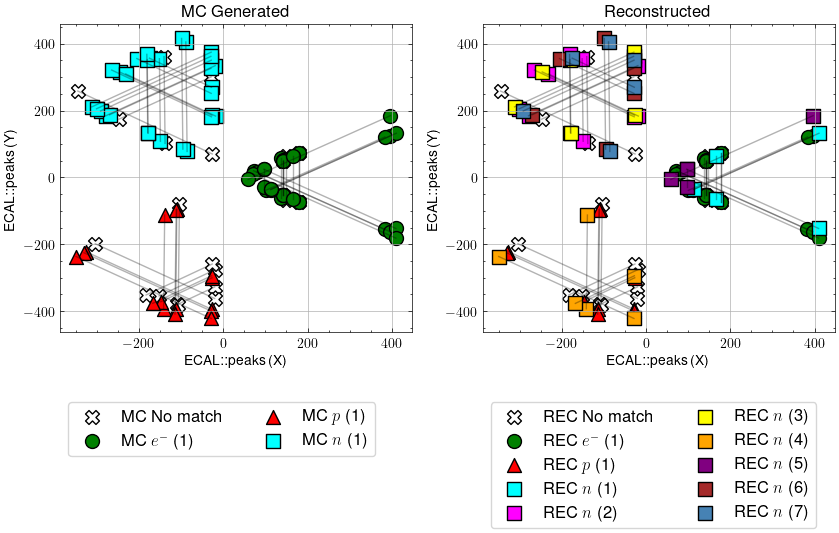

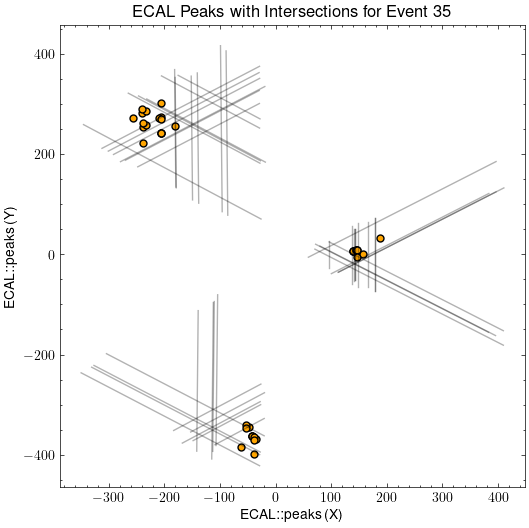

In [47]:
plot_ecal_peaks(filename, event_number=35)
plot_ecal_peaks_with_intersections(filename, filename_intersection,event_number=35)

In [17]:
intersection_files[rand]

'../../projects/test.epn.08.12.2024.21.50/training/___1.0___30.0___0.0___0.01___0.01___0.01___neutron___-intersections.csv'

# Load in Training Data

In [22]:
data = TrainData(csv_files = intersection_files,
                 train_size = 0.8,
                 graph = True,
                 k_nearest_neighbors=3,
                 min_intersections=10)

Total files processed: 361
Total intersections found: 175785


In [23]:
train_data = data.get_train_data()

# Create GNN model

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

In [25]:
class GNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dims):
        """
        Initialize the GNNModel with a specified number of hidden GNN layers and dimensions.

        Parameters:
        -----------
        input_dim : int
            The dimension of the input features.
        hidden_dims : list of int
            A list specifying the hidden dimension size for each GNN layer.
        """
        super(GNNModel, self).__init__()
        
        # Initialize the list of GNN layers
        self.convs = nn.ModuleList()
        
        # Create GNN layers dynamically based on hidden_dims
        for i, hidden_dim in enumerate(hidden_dims):
            in_channels = input_dim if i == 0 else hidden_dims[i-1]
            self.convs.append(GCNConv(in_channels, hidden_dim))
        
        # Final output dimensions after concatenation
        concat_dim = sum(hidden_dims)
        
        # Prediction layers
        self.fc_beta = nn.Linear(concat_dim, 1)   # Single output for beta
        self.fc_latent_x = nn.Linear(concat_dim, 1)
        self.fc_latent_y = nn.Linear(concat_dim, 1)
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        hidden_representations = []

        # Pass through each GNN layer and collect the outputs
        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)
            hidden_representations.append(x)
        
        # Concatenate all hidden representations
        x_concat = torch.cat(hidden_representations, dim=1)
        
        # Predict beta (sigmoid output)
        beta = torch.sigmoid(self.fc_beta(x_concat))
        
        # Predict latent_x and latent_y
        latent_x = self.fc_latent_x(x_concat)
        latent_y = self.fc_latent_y(x_concat)
        
        return torch.cat((beta, latent_x, latent_y), dim=1)

# Initialize Model

In [28]:
from torch_geometric.loader import DataLoader

input_dim = 30        # Number of input features
hidden_dims = [48,64,128]     # Number of hidden units in GNN layers
batch_size = 128       # Batch size
learning_rate = 0.1  # Learning rate
N_epochs   = 100       # Number of epochs to train

# Create model
model = GNNModel(input_dim, hidden_dims)

# Setup batching
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Setup optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Setup GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
model.to(device)

GNNModel(
  (convs): ModuleList(
    (0): GCNConv(30, 48)
    (1): GCNConv(48, 64)
    (2): GCNConv(64, 128)
  )
  (fc_beta): Linear(in_features=240, out_features=1, bias=True)
  (fc_latent_x): Linear(in_features=240, out_features=1, bias=True)
  (fc_latent_y): Linear(in_features=240, out_features=1, bias=True)
)

In [49]:
# Training loop
for epoch in range(N_epochs):  # Train over N_epochs
    
    for ib,batch in enumerate(train_loader):   # Batch
        
        # Load ECAL Data from batch
        data = batch.to(device)
        
        object_ids = data.y
        
        # Zero optimizer gradients
        optimizer.zero_grad()
        
        # Compute output
        out = model(data)
        
        # Pull output from the model
        beta = out[:,0]
        clustering_coords = out[:,1:]
        
        # Calculate components of the condensation loss
        loss_dict = condensation_loss(
            beta=beta.squeeze(),
            x=clustering_coords,
            object_id=object_ids.squeeze(),
            q_min=0.01,
            noise_threshold=0
        )
        
        
        loss = loss_dict['attractive'] + loss_dict['repulsive'] + loss_dict['coward']
        
        loss.backward()
        optimizer.step()
        sys.stdout.write(f'\rEpoch [{epoch+1}/{N_epochs}] | Batch {ib+1} | '
                         f'loss_attractive = {loss_dict["attractive"]:.6f} | '
                         f'loss_repulsive  = {loss_dict["repulsive"]:.6f} | '
                         f'loss_coward     = {loss_dict["coward"]:.6f} | '
                         f'loss_noise      = {loss_dict["noise"]:.6f} | '
                         f'loss_total      = {loss.item():.6f}')
        sys.stdout.flush()
    # Print the final value for the epoch
    print(f'\rEpoch [{epoch+1}/{N_epochs}] completed | '
          f'loss_attractive = {loss_dict["attractive"]:.6f} | '
          f'loss_repulsive  = {loss_dict["repulsive"]:.6f} | '
          f'loss_coward     = {loss_dict["coward"]:.6f} | '
          f'loss_noise      = {loss_dict["noise"]:.6f}| '
          f'loss_total      = {loss.item():.6f}')


Epoch [1/100] completed | loss_attractive = 0.047974 | loss_repulsive  = 0.050420 | loss_coward     = 0.262391 | loss_noise      = 0.563888| loss_total      = 0.36078585
Epoch [2/100] completed | loss_attractive = 0.040710 | loss_repulsive  = 0.053264 | loss_coward     = 0.265334 | loss_noise      = 0.508477| loss_total      = 0.35930808
Epoch [3/100] completed | loss_attractive = 0.044757 | loss_repulsive  = 0.078685 | loss_coward     = 0.224423 | loss_noise      = 0.624659| loss_total      = 0.34786565
Epoch [4/100] completed | loss_attractive = 0.020855 | loss_repulsive  = 0.068801 | loss_coward     = 0.215671 | loss_noise      = 0.565456| loss_total      = 0.30532828
Epoch [5/100] completed | loss_attractive = 0.018507 | loss_repulsive  = 0.052081 | loss_coward     = 0.267453 | loss_noise      = 0.542508| loss_total      = 0.33804141
Epoch [6/100] completed | loss_attractive = 0.050400 | loss_repulsive  = 0.065557 | loss_coward     = 0.198396 | loss_noise      = 0.594032| loss_tota

KeyboardInterrupt: 

In [50]:
from copy import deepcopy
import matplotlib.pyplot as plt
td = deepcopy(train_data)

In [51]:
# Define the colors
colors = [
    (0.000, 0.000, 1.000),
    (0.000, 0.502, 0.000),
    (1.000, 0.000, 0.000),
    (0.000, 1.000, 1.000),
    (1.000, 0.000, 1.000),
    (1.000, 1.000, 0.000),
    (1.000, 0.647, 0.000),
    (0.502, 0.000, 0.502),
    (0.647, 0.165, 0.165),
    (0.275, 0.510, 0.706),
    (0.980, 0.502, 0.447),
    (0.824, 0.706, 0.549),
    (0.941, 0.902, 0.549),
    (0.502, 0.502, 0.502),
    (0.529, 0.808, 0.922),
    (0.941, 0.502, 0.502),
    (0.502, 0.000, 0.000),
    (0.184, 0.310, 0.310),
    (0.000, 0.749, 1.000)
]

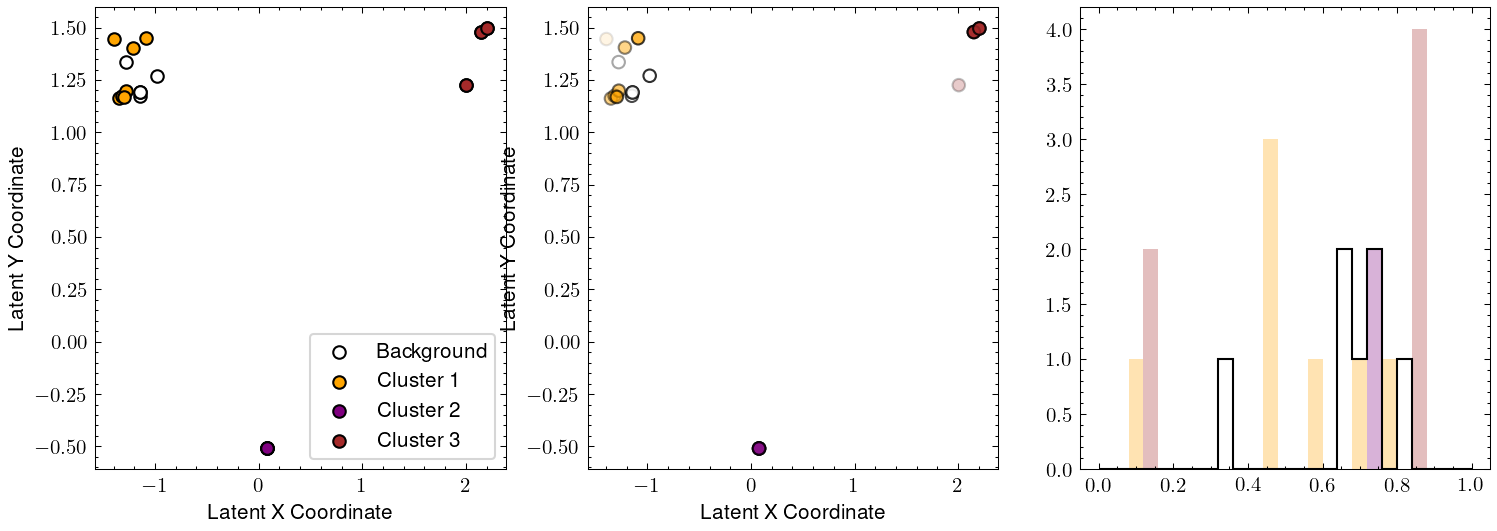

In [52]:
fig,axs=plt.subplots(1,3,figsize=(12,4),dpi=150)

for event in [1101]:

    out = model(td[event].to(device)).T.cpu().detach()
    object_ids = td[event].y
    
    beta = out[0]
    xc = out[1]
    yc = out[2]

    obj_counter = 0
    for object_id in sorted(object_ids.unique()):
        idx = object_ids==object_id
        idx = idx.cpu().detach()
        if object_id == -1:
            axs[0].scatter(xc[idx],yc[idx],edgecolor="k",color="white",label="Background")
            axs[1].scatter(xc[idx],yc[idx],edgecolor="k",color="white",alpha=beta[idx])
            axs[2].hist(beta[idx],range=(0,1),bins=25,edgecolor="black",zorder=10,histtype="step")
        else:
            color_id = object_id%len(colors)
            color = colors[color_id]
            axs[0].scatter(xc[idx],yc[idx],edgecolor="k",color=color,label=f"Cluster {obj_counter+1}")
            axs[1].scatter(xc[idx],yc[idx],edgecolor="k",color=color,alpha=beta[idx])
            axs[2].hist(beta[idx],range=(0,1),bins=25,color=color,alpha=0.3)
            obj_counter+=1
    axs[0].legend(frameon=True)
    axs[0].set_xlabel("Latent X Coordinate")
    axs[0].set_ylabel("Latent Y Coordinate")
    axs[1].set_xlabel("Latent X Coordinate")
    axs[1].set_ylabel("Latent Y Coordinate")
    
    